In [30]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from urllib.request import urlopen
import json
from shapely.geometry import shape

In [31]:
# Configure pandas display options
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set up base directory
BASE_DIR = "../AP-Data/data/2024"

# Define party colors - expanded to include all possible parties
PARTY_COLORS = {
    'GOP': '#E81B23',    # Republican Red
    'Dem': '#00AEF3',    # Democratic Blue
    'Lib': '#FED105',    # Libertarian Gold
    'Grn': '#00A95C',    # Green Party Green
    'PEC': '#800080',    # People's Party Purple
    'Aur': '#FF7F00',    # Alliance Party Orange
    'CST': '#964B00',    # Constitution Party Brown
    'ASP': '#808080',    # American Solidarity Party Gray
    'Ind': '#4B0082',    # Independent Indigo
    'Oth': '#708090'     # Other Slate Gray
}

def get_party_color(party):
    """Get color for party, return gray if party not in dictionary"""
    return PARTY_COLORS.get(party, '#708090')  # Default to slate gray for unknown parties

In [32]:
def load_election_data(file_name='president_2024.csv'):
    """Load and process the presidential election results"""
    file_path = os.path.join(BASE_DIR, file_name)
    return pd.read_csv(file_path)

def load_electoral_votes(file_name='electoral_votes.csv'):
    """Load electoral vote data including historical data"""
    file_path = os.path.join('data', file_name)
    return pd.read_csv(file_path)

# Load the data
raw_data = load_election_data()
ev_data = load_electoral_votes()

# Create dictionary for current electoral votes
electoral_votes = ev_data.set_index('state_postal')['electoral_votes_2020'].to_dict()

Changes in Electoral Votes from 2010 to 2020:


,state_name,electoral_votes_2010,electoral_votes_2020,ev_change
43,Texas,38,40,2
9,Florida,29,30,1
37,Oregon,7,8,1
26,Montana,3,4,1
5,Colorado,9,10,1
33,North Carolina,15,16,1
22,Michigan,16,15,-1
4,California,55,54,-1
13,Illinois,20,19,-1
35,Ohio,18,17,-1


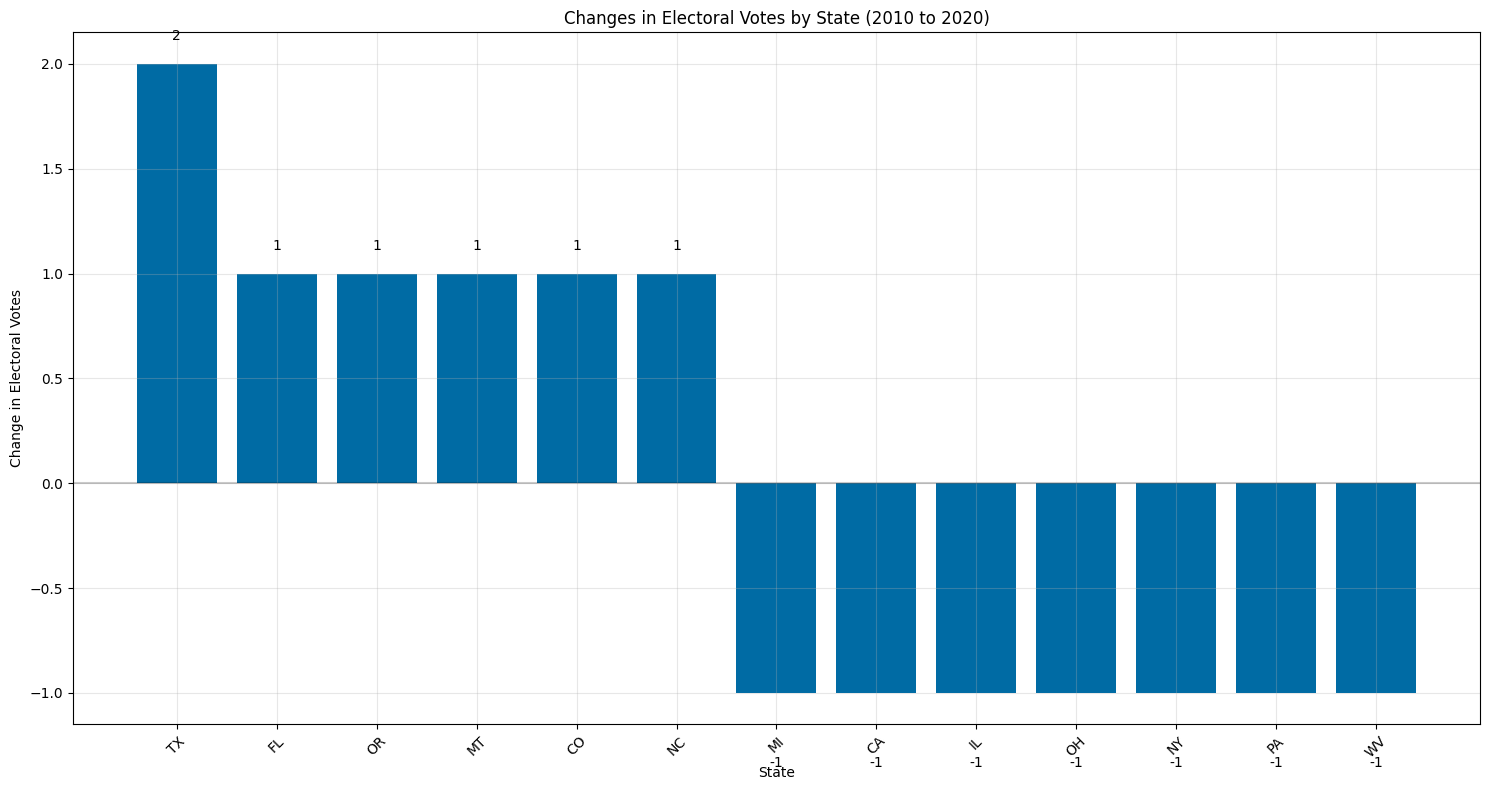


Electoral Vote Reapportionment Summary:
-------------------------------------
• 13 states had electoral vote changes
• 6 states gained votes
• 7 states lost votes
• Total electoral votes redistributed: 7



In [33]:
# Analyze changes in electoral votes
ev_data['ev_change'] = ev_data['electoral_votes_2020'] - ev_data['electoral_votes_2010']

# Display states that gained or lost electoral votes
print("Changes in Electoral Votes from 2010 to 2020:")
changes = ev_data[ev_data['ev_change'] != 0].sort_values('ev_change', ascending=False)
display(changes[['state_name', 'electoral_votes_2010', 'electoral_votes_2020', 'ev_change']])

# Visualize electoral vote changes
plt.figure(figsize=(15, 8))
plt.bar(changes['state_postal'], changes['ev_change'])
plt.title('Changes in Electoral Votes by State (2010 to 2020)')
plt.xlabel('State')
plt.ylabel('Change in Electoral Votes')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add value labels on the bars
for i, v in enumerate(changes['ev_change']):
    plt.text(i, v + (0.1 if v >= 0 else -0.3), 
             str(int(v)), 
             ha='center',
             va='bottom' if v >= 0 else 'top')

plt.tight_layout()
plt.show()

# Calculate summary statistics
total_changed = len(changes)
total_gained = len(changes[changes['ev_change'] > 0])
total_lost = len(changes[changes['ev_change'] < 0])
sum_gained = changes[changes['ev_change'] > 0]['ev_change'].sum()

print(f"""
Electoral Vote Reapportionment Summary:
-------------------------------------
• {total_changed} states had electoral vote changes
• {total_gained} states gained votes
• {total_lost} states lost votes
• Total electoral votes redistributed: {int(sum_gained)}
""")

National Vote Totals:


,vote_count,vote_pct,vote_count_formatted
party,,,
GOP,147659636,50.76,"147,659,636"
Dem,138835597,47.72,"138,835,597"
Grn,1220663,0.42,"1,220,663"
Lib,1170277,0.40,"1,170,277"
Ind,1051188,0.36,"1,051,188"
WTP,175848,0.06,"175,848"
PSL,151008,0.05,"151,008"
AIP,116095,0.04,"116,095"
JfA,96528,0.03,"96,528"


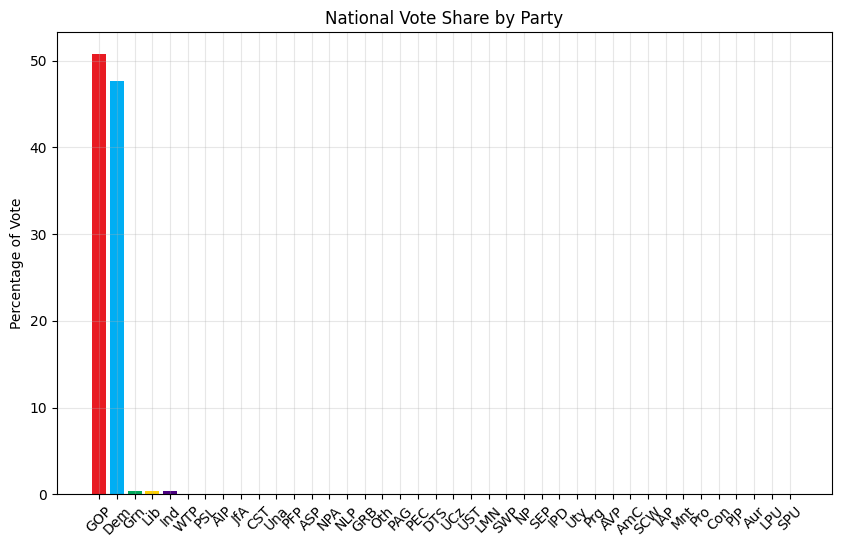

In [34]:
# Calculate national summary
national_summary = raw_data.groupby('party').agg({
    'vote_count': 'sum',
}).sort_values('vote_count', ascending=False)

national_summary['vote_pct'] = national_summary['vote_count'] / national_summary['vote_count'].sum() * 100
national_summary['vote_count_formatted'] = national_summary['vote_count'].apply(lambda x: f"{x:,}")

print("National Vote Totals:")
display(national_summary)

# Plot national results with party colors
plt.figure(figsize=(10, 6))
party_colors = [get_party_color(party) for party in national_summary.index]
plt.bar(national_summary.index, national_summary['vote_pct'], color=party_colors)
plt.title('National Vote Share by Party')
plt.ylabel('Percentage of Vote')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

Electoral Vote Totals:


party
GOP   312.00
Dem   226.00
Name: electoral_votes, dtype: float64

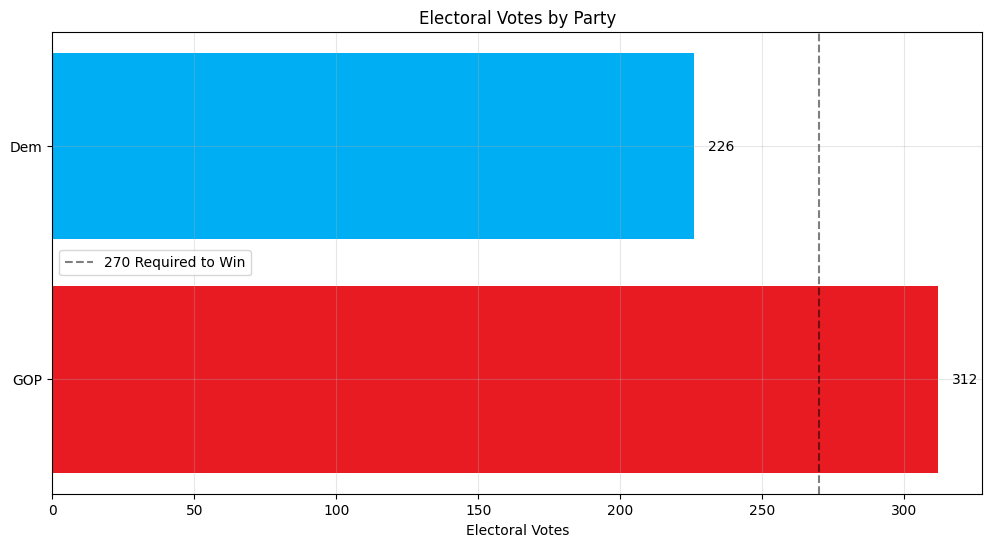

In [35]:
# Add electoral votes to state results
state_results['electoral_votes'] = state_results['state_postal'].map(electoral_votes)

# Calculate electoral vote totals
electoral_summary = state_results.groupby('party')['electoral_votes'].sum().sort_values(ascending=False)

print("Electoral Vote Totals:")
display(electoral_summary)

# Create a horizontal bar chart of electoral votes with party colors
plt.figure(figsize=(12, 6))
party_colors_ev = [get_party_color(party) for party in electoral_summary.index]
bars = plt.barh(range(len(electoral_summary)), electoral_summary.values, color=party_colors_ev)
plt.yticks(range(len(electoral_summary)), electoral_summary.index)
plt.axvline(x=270, color='black', linestyle='--', alpha=0.5, label='270 Required to Win')
plt.title('Electoral Votes by Party')
plt.xlabel('Electoral Votes')
plt.grid(True, alpha=0.3)
plt.legend()

# Add value labels on the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 5, i, f'{int(width)}', 
             va='center', ha='left')
plt.show()


State-by-State Margin Verification:
--------------------------------------------------------------------------------
State           Winner   Margin   Vote %   EV
--------------------------------------------------------------------------------
AK              GOP     -15.12    55.53  3.0
AL              GOP     -30.61    64.83  9.0
AR              GOP     -30.72    64.24  6.0
AZ              GOP      -5.88    52.48 11.0
CA              Dem      17.86    57.60 54.0
CO              Dem      11.65    54.56 10.0
CT              Dem      14.09    56.20  7.0
DC              Dem      85.81    92.48  3.0
DE              Dem      14.75    56.63  3.0
FL              GOP     -13.13    56.10 30.0
GA              GOP      -2.23    50.75 16.0
HI              Dem      23.13    60.60  4.0
IA              GOP     -13.26    55.95  6.0
ID              GOP     -36.51    66.89  4.0
IL              Dem       8.58    53.57 19.0
IN              GOP     -18.92    58.61 11.0
KS              GOP     -16.35    5

C:\Users\elian\AppData\Local\Temp\ipykernel_31816\2073890169.py:244: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


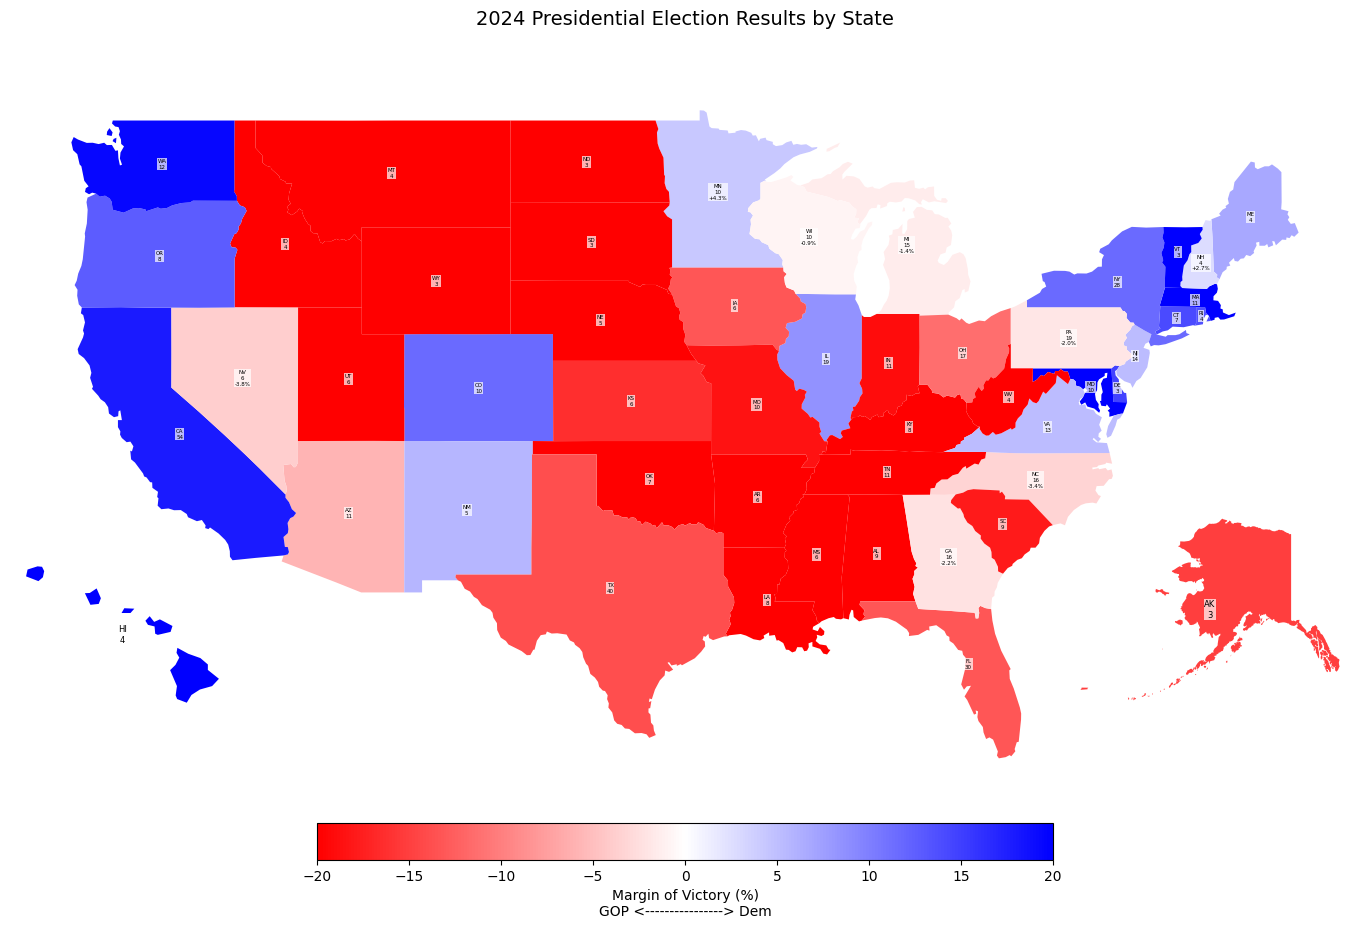

In [58]:


# Configure pandas display options
pd.set_option('display.float_format', lambda x: '%.2f' % x)

def load_us_map():
    """Load US states GeoJSON data"""
    
    # URL for US states GeoJSON
    url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
    
    try:
        # Read GeoJSON from URL
        with urlopen(url) as response:
            states_json = json.load(response)
        
        # Convert to GeoDataFrame
        states = []
        for feature in states_json["features"]:
            state_name = feature["properties"]["name"]
            geom = shape(feature["geometry"])
            states.append({"name": state_name, "geometry": geom})
        
        us_map = gpd.GeoDataFrame(states)
        us_map.set_geometry('geometry', inplace=True)
        us_map.crs = "EPSG:4326"  # Set coordinate reference system
        
        # Add state postal codes
        state_codes = {
            'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
            'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
            'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
            'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
            'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
            'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
            'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
            'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
            'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
            'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
        }
        us_map['state_postal'] = us_map['name'].map(state_codes)
        
        return us_map
    
    except Exception as e:
        print(f"Error loading map data: {e}")
        return None

def check_state_results(state_data):
    """Print detailed results for each state to verify calculations"""
    print("\nState-by-State Margin Verification:")
    print("-" * 80)
    print(f"{'State':<15} {'Winner':<5} {'Margin':>8} {'Vote %':>8} {'EV':>4}")
    print("-" * 80)
    
    for _, row in state_data.sort_values('state_postal').iterrows():
        print(f"{row['state_postal']:<15} {row['party']:<5} {row['margin']:>8.2f} {row['vote_pct']:>8.2f} {row['electoral_votes']:>4}")

def calculate_state_margins(raw_data):
    """Calculate state-level results and margins"""
    # Get total votes by state and party
    state_party_votes = raw_data.pivot_table(
        index='state_postal',
        columns='party',
        values='vote_count',
        aggfunc='sum',
        fill_value=0
    )
    
    # Calculate total votes per state
    state_party_votes['total'] = state_party_votes.sum(axis=1)
    
    # Calculate margin (Dem - GOP as percentage)
    state_party_votes['margin'] = (
        (state_party_votes['Dem'] - state_party_votes['GOP']) / 
        state_party_votes['total'] * 100
    )
    
    # Get winning party for each state
    state_results = raw_data.loc[raw_data.groupby('state_postal')['vote_count'].idxmax()]
    
    # Merge margins and total votes with state results
    state_results = state_results.merge(
        state_party_votes[['margin', 'total']],  # Include total in the merge
        on='state_postal',
        how='left'
    )
    
    # Calculate vote percentage using the total from pivot table
    state_results['vote_count_total'] = state_results['total']  # Use merged total
    state_results['vote_pct'] = (state_results['vote_count'] / state_results['total'] * 100)
    
    # Drop the temporary total column
    state_results = state_results.drop('total', axis=1)
    
    return state_results

def create_election_map(election_data, us_map):
    """Create choropleth map of election results with insets for AK and HI"""
    if us_map is None:
        print("Unable to create map: No map data available")
        return None, None
        
    us_map = us_map.dropna(subset=['state_postal'])
    election_data = election_data.dropna(subset=['state_postal'])

    merged = us_map.merge(election_data, on='state_postal', how='left')
    
    # Create figure with a specific size
    fig = plt.figure(figsize=(15, 10))
    
    # Create the main map axes, leaving space for Alaska and Hawaii
    ax_main = fig.add_axes([0.05, 0.1, 0.9, 0.8])
    
    # Create inset axes for Alaska and Hawaii
    ax_ak = fig.add_axes([0.75, .25, 0.2, 0.2])  # Alaska
    ax_hi = fig.add_axes([0.05, 0.25, 0.15, 0.15])  # Hawaii

    # Custom colormap
    colors = [
        '#FF0000',  # Strong Red
        '#FF8080',  # Light Red
        '#FFFFFF',  # White
        '#8080FF',  # Light Blue
        '#0000FF'   # Strong Blue
    ]
    cm = LinearSegmentedColormap.from_list('custom', colors, N=256)
    
    # Plot main map
    merged_mainland = merged[~merged['state_postal'].isin(['AK', 'HI'])]
    merged_mainland.plot(
        column='margin',
        ax=ax_main,
        cmap=cm,
        legend=True,
        legend_kwds={
            'label': 'Margin of Victory (%)\nGOP <----------------> Dem',
            'orientation': 'horizontal',
            'fraction': 0.046,
            'pad': 0.04,
        },
        missing_kwds={'color': 'lightgrey'},
        vmin=-20,
        vmax=20
    )
    
    # Plot Alaska inset
    merged_ak = merged[merged['state_postal'] == 'AK']
    if not merged_ak.empty:
        merged_ak.plot(
            column='margin',
            ax=ax_ak,
            cmap=cm,
            vmin=-20,
            vmax=20
        )
    
    # Plot Hawaii inset
    merged_hi = merged[merged['state_postal'] == 'HI']
    if not merged_hi.empty:
        merged_hi.plot(
            column='margin',
            ax=ax_hi,
            cmap=cm,
            vmin=-20,
            vmax=20
        )
    
    # Customize all axes
    for ax in [ax_main, ax_ak, ax_hi]:
        ax.axis('off')
    
    # Main title
    plt.suptitle('2024 Presidential Election Results by State', fontsize=14, y=0.95)
    
    # Add state labels to main map with smaller text and less information
    for idx, row in merged_mainland.iterrows():
        centroid = row.geometry.centroid
        ev = electoral_votes.get(row['state_postal'], '')
        
        # Only show state code and electoral votes, with smaller font
        label_text = f"{row['state_postal']}\n{ev}"
        
        # For states with narrow margins (< 5%), add margin
        if abs(row['margin']) < 5:
            label_text += f"\n{row['margin']:+.1f}%"
        
        ax_main.annotate(
            label_text,
            xy=(centroid.x, centroid.y),
            xytext=(0, 0),
            textcoords="offset points",
            ha='center',
            va='center',
            fontsize=4,  # Smaller font size
            bbox=dict(
                facecolor='white',
                alpha=0.7,
                edgecolor='none',
                pad=0.5  # Smaller padding
            )
        )
    
    # Add labels for AK and HI
    for ax, data, state in [(ax_ak, merged_ak, 'AK'), (ax_hi, merged_hi, 'HI')]:
        if not data.empty:
            ev = electoral_votes.get(state, '')
            margin = data.iloc[0]['margin']
            label_text = f"{state}\n{ev}"
            if abs(margin) < 5:
                label_text += f"\n{margin:+.1f}%"
            
            # Center the label in the inset
            ax.annotate(
                label_text,
                xy=(0.5, 0.5),
                xycoords='axes fraction',
                ha='center',
                va='center',
                fontsize=6,
                bbox=dict(
                    facecolor='white',
                    alpha=0.7,
                    edgecolor='none',
                    pad=0.5
                )
            )
    
    
    return fig, [ax_main, ax_ak, ax_hi]

# Calculate state results with correct margins
state_results = calculate_state_margins(raw_data)

# Add electoral votes
state_results['electoral_votes'] = state_results['state_postal'].map(electoral_votes)

# Check the results
check_state_results(state_results)

# Create and display the map
us_map = load_us_map()
if us_map is not None:
    fig, ax = create_election_map(state_results, us_map)
    if fig is not None:
        plt.tight_layout()
        plt.show()

In [60]:
# Calculate key statistics
total_votes = national_summary['vote_count'].sum()
winner_votes = national_summary['vote_count'].iloc[0]
winner_pct = national_summary['vote_pct'].iloc[0]
winner_party = national_summary.index[0]
margin_of_victory = national_summary['vote_pct'].iloc[0] - national_summary['vote_pct'].iloc[1]
close_states = len(state_results[abs(state_results['margin']) < 1])
closest_state = state_results.loc[state_results['margin'].abs().idxmin()]

print(f"""Key Election Statistics:

1. Voter Turnout:
   - Total votes cast: {total_votes:,}
   
2. Popular Vote:
   - Winner ({winner_party}): {winner_votes:,} votes ({winner_pct:.1f}%)
   - Margin of victory: {margin_of_victory:+.1f}%
   
3. Electoral College:
   - {winner_party} electoral votes: {electoral_summary.iloc[0]:,}
   - Needed to win: 270
   
4. Battleground States:
   - States decided by <1%: {close_states}
   - Closest state: {closest_state['state_name']} ({closest_state['margin']:+.2f}%)
""")

Key Election Statistics:

1. Voter Turnout:
   - Total votes cast: 290,919,925
   
2. Popular Vote:
   - Winner (GOP): 147,659,636 votes (50.8%)
   - Margin of victory: +3.0%
   
3. Electoral College:
   - GOP electoral votes: 312.0
   - Needed to win: 270
   
4. Battleground States:
   - States decided by <1%: 1
   - Closest state: Wisconsin (-0.86%)

